# Data Preparation
- Query from 5 tables on `ai300_capstone` database
- Data Dictionary: https://heicodersacademy.notion.site/Data-Dictionary-fc1b2fd7c2ad420494b9194ff44fc4be

In [2]:
# General
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import warnings, os
warnings.filterwarnings("ignore")

# Data Prep
from sqlalchemy import create_engine

# EDA
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import product
import scipy.stats as ss

# Feature Engr
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Train Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Hyperparameters Optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna.pruners import HyperbandPruner

# Ensemble Learning
import lightgbm as lgb
from catboost import CatBoostClassifier

# Model Evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification

# Deployment
import joblib

c:\Users\carlo\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
ENDPOINT = 'heicoders-playground.c2ced10ceyki.ap-southeast-1.rds.amazonaws.com'
PORT = 3306
USERNAME = 'student300'
PASSWORD = 'heicoders_AI300'
DBNAME = 'ai300_capstone'

database_conn = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DBNAME}')

## use "Using" will eliminate the duplicated joined columns
query = """
    SELECT * 
        FROM customer c
        LEFT JOIN account a
            USING (customer_id)
        LEFT JOIN account_usage au
            USING(account_id)
        LEFT JOIN city
            USING(zip_code)
        LEFT JOIN churn_status as cs
            USING(customer_id)
        ORDER BY c.customer_id, a.account_id
"""

df = pd.read_sql(query, database_conn)
df

,customer_id,zip_code,account_id,gender,age,senior_citizen,married,num_dependents,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,contract_type,paperless_billing,payment_method,avg_long_distance_fee_monthly,total_long_distance_fee,avg_gb_download_monthly,stream_tv,stream_movie,stream_music,total_monthly_fee,total_charges_quarter,total_refunds,area_id,city,latitude,longitude,population,status,churn_label,churn_category,churn_reason
0,0002-ORFBO,93225,XSWV-PAYXZ,Female,37,No,Yes,0,9,2,Yes,Cable,Yes,Yes,No,Yes,No,Yes,No,One Year,Yes,Credit Card,42.39,381.51,16,Yes,No,No,65.60,593.30,0.00,649,Frazier Park,34.827662,-118.999073,4498,Stayed,No,,
1,0003-MKNFE,91206,VFUN-NFDPJ,Male,46,No,No,0,9,0,Yes,Cable,No,Yes,Yes,No,No,No,No,Month-to-Month,No,Credit Card,10.69,96.21,10,No,Yes,Yes,59.90,542.40,38.33,184,Glendale,34.162515,-118.203869,31297,Stayed,No,,
2,0004-TLHLJ,92627,NFEJ-WVYXF,Male,50,No,No,0,4,0,Yes,Fiber Optic,Yes,Yes,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,33.65,134.60,30,No,No,No,73.90,280.85,0.00,535,Costa Mesa,33.645672,-117.922613,62069,Churned,Yes,Competitor,Competitor had better devices
3,0011-IGKFF,94553,VOAC-QSDER,Male,78,Yes,Yes,0,13,1,Yes,Fiber Optic,Yes,Yes,No,No,No,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,27.82,361.66,4,Yes,Yes,No,98.00,1237.85,0.00,960,Martinez,38.014457,-122.115432,46677,Churned,Yes,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,93010,BFIN-DLMOA,Female,75,Yes,Yes,0,3,3,Yes,Fiber Optic,Yes,Yes,No,Yes,No,No,No,Month-to-Month,Yes,Credit Card,7.38,22.14,11,Yes,No,No,83.90,267.40,0.00,607,Camarillo,34.227846,-119.079903,42853,Churned,Yes,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,91941,HDCC-OWUTY,Female,20,No,No,0,13,0,Yes,DSL,Yes,Yes,No,Yes,Yes,No,No,One Year,No,Credit Card,46.68,606.84,59,No,No,Yes,55.15,742.90,0.00,302,La Mesa,32.759327,-116.997260,44652,Stayed,No,,
7039,9992-RRAMN,95367,TUYF-QYLVG,Male,40,No,Yes,0,22,1,Yes,Fiber Optic,Yes,Yes,Yes,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,16.20,356.40,17,No,Yes,Yes,85.10,1873.70,0.00,1207,Riverbank,37.734971,-120.954271,16525,Churned,Yes,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,95432,PCTD-RXANG,Male,22,No,No,0,2,0,Yes,DSL,Yes,Yes,No,No,No,Yes,No,Month-to-Month,Yes,Credit Card,18.62,37.24,51,No,No,No,50.30,92.75,0.00,1242,Elk,39.108252,-123.645121,383,Joined,No,,
7041,9993-LHIEB,92075,JKGN-GMTXE,Male,21,No,Yes,0,67,5,Yes,Cable,Yes,Yes,No,Yes,Yes,No,Yes,Two Year,No,Credit Card,2.12,142.04,58,No,Yes,Yes,67.85,4627.65,0.00,343,Solana Beach,33.001813,-117.263628,12173,Stayed,No,,


In [ ]:
df.to_excel(r"Data\Customer_Churn_Data.xlsx", index = False)

# Data Exploration
## a. Data Types & NULL values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    7043 non-null   object 
 1   zip_code                       7043 non-null   int64  
 2   account_id                     7043 non-null   object 
 3   gender                         7043 non-null   object 
 4   age                            7043 non-null   int64  
 5   senior_citizen                 7043 non-null   object 
 6   married                        7043 non-null   object 
 7   num_dependents                 7043 non-null   int64  
 8   tenure_months                  7043 non-null   int64  
 9   num_referrals                  7043 non-null   int64  
 10  has_internet_service           7043 non-null   object 
 11  internet_type                  7043 non-null   object 
 12  has_unlimited_data             7043 non-null   o

<div class="alert alert-block alert-success">

- No NULL values but there are blank values
- `zip_code`, `area_id`, `lattitude` & `longitude` are having incorrect data type. To be converted from float/int to string

In [7]:
dt_ls = ['zip_code', 'area_id', 'latitude', 'longitude']

for dt in dt_ls:
    df[dt] = df[dt].astype(str)

df[dt_ls].dtypes

zip_code     object
area_id      object
latitude     object
longitude    object
dtype: object

<div class="alert alert-block alert-info">

<b>Info about US Postal Code:</b>
- 1st Digit: Group of states or a specific region within a state
- 2nd Digit: Narrows down the area within the state or region
- 3rd Digit Further refines the area, typically specifying a city or a group of nearby cities.
- 4th digit indicates a specific geographic segment within the city or region.
- 5th digit, also known as the ZIP code suffix, represents a specific post office or delivery area

To reduce the cardinality of zip code column, so that the com has enough RAM to train the model

In [8]:
df['zip_code'] = df['zip_code'].str[:2]
df['zip_code'].unique()

array(['93', '91', '92', '94', '95', '96', '90'], dtype=object)

## b. Explore Numeric Variables

In [9]:
df.select_dtypes(exclude = ['object']).describe().T

,count,mean,std,min,25%,50%,75%,max
age,7043.0,46.509726,16.750352,19.00,32.000,46.00,60.000,80.00
num_dependents,7043.0,0.468692,0.962802,0.00,0.000,0.00,0.000,9.00
tenure_months,7043.0,32.386767,24.542061,1.00,9.000,29.00,55.000,72.00
num_referrals,7043.0,1.951867,3.001199,0.00,0.000,0.00,3.000,11.00
avg_long_distance_fee_monthly,7043.0,22.958954,15.448113,0.00,9.210,22.89,36.395,49.99
total_long_distance_fee,7043.0,749.099262,846.660055,0.00,70.545,401.44,1191.100,3564.72
avg_gb_download_monthly,7043.0,20.515405,20.418940,0.00,3.000,17.00,27.000,85.00
total_monthly_fee,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.850,118.75
total_charges_quarter,7043.0,2280.381264,2266.220462,18.80,400.150,1394.55,3786.600,8684.80
total_refunds,7043.0,1.962182,7.902614,0.00,0.000,0.00,0.000,49.79


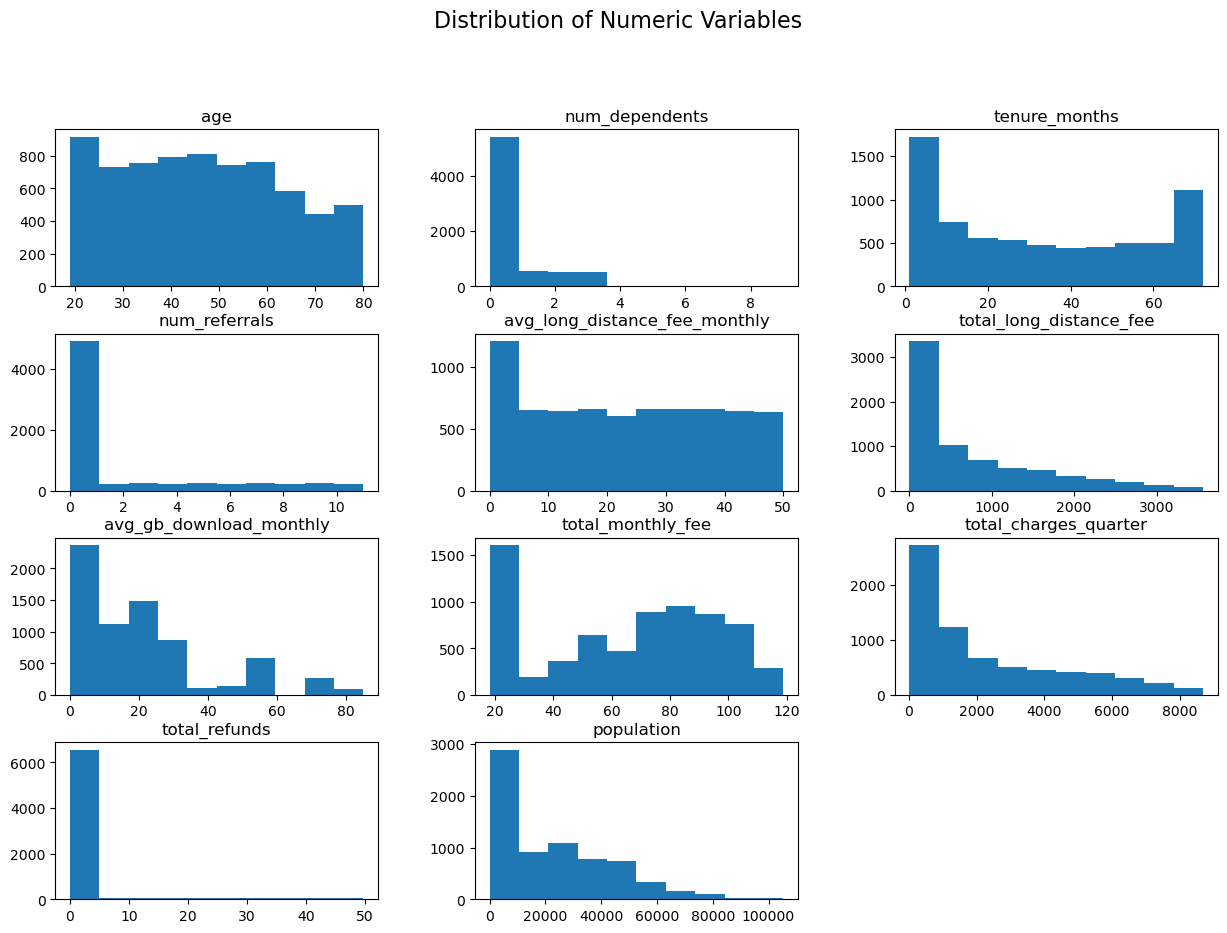

In [10]:
df_num = df.select_dtypes(exclude = 'object')

df_num.fillna("").hist(bins = 10, figsize=(15,10), grid = False)
plt.suptitle('Distribution of Numeric Variables', y=1, fontsize=16)
plt.show()

<div class="alert alert-block alert-success">

<b>Highly skewed features:</b> `num_dependent`, `num_referrals`, `total_refunds` & `total_long_distance_fee`
- Consider to bin `num_dependent` & `num_referrals` as they are discrete data and majority of data falls under 0 -- as a way to handle zero or outlier
- `total_long_distance_fee` will need to undergo transformation to bring down the skewness

<b>Slightly skewed features:</b> `tenure_months`, `population` and `avg_gb_download_monthly`
-  Consider to undergo scaling methods

## c. Determine Correlation of Numeric Features

In [11]:
# df_num = df.select_dtypes(exclude = 'object')

corr = df_num.corr().round(2)

#Creating a heat map of all the numerical features.
fig = px.imshow(corr, aspect = 'auto', color_continuous_scale= 'RdBu', text_auto= True)
fig.update_xaxes(side="top")

fig.layout.height = 750
# fig.layout.width = 1000
fig.show()

<div class="alert alert-block alert-success">

From the heat map, we can deduce some positive correlations: 
- tenure_months ↔ total_charges_quarter
- tenure_months ↔ total_long_distance_fee
- avg_long_distance_fee_monthly ↔ total_long_distance_fee_monthly
- total_long_distance_fee_monthly ↔ total_charges_quarter

Additionally, we can deduce some negative correlations:
- age ↔ avg_gb_download_monthly

## d. Explore Categorical Variables

In [12]:
df.select_dtypes(include = ['object']).isnull().sum()

customer_id                 0
zip_code                    0
account_id                  0
gender                      0
senior_citizen              0
married                     0
has_internet_service        0
internet_type               0
has_unlimited_data          0
has_phone_service           0
has_multiple_lines          0
has_premium_tech_support    0
has_online_security         0
has_online_backup           0
has_device_protection       0
contract_type               0
paperless_billing           0
payment_method              0
stream_tv                   0
stream_movie                0
stream_music                0
area_id                     0
city                        0
latitude                    0
longitude                   0
status                      0
churn_label                 0
churn_category              0
churn_reason                0
dtype: int64

In [13]:
# Find out the num of instances for each churn status
df['churn_label'].value_counts()

churn_label
No     5174
Yes    1817
         52
Name: count, dtype: int64

In [14]:
# Understand records without churn label
display(df[df['churn_label']=='']['churn_category'].unique())
display(df[df['churn_label']=='']['churn_reason'].unique())

array(['Other'], dtype=object)

array(['Deceased', 'Moved'], dtype=object)

In [15]:
# list all the columns with data type as string
cat_cols = df.select_dtypes('object').columns
cat_cols_eda = list(set(cat_cols) - set(['customer_id', 'account_id', 'city', 'status', 'churn_label', 'churn_category', 'churn_reason', 'area_id', 'latitude', 'longitude']))

for col in cat_cols_eda:
    churn_grp = df.groupby(col)['churn_label'].value_counts(normalize= True).round(2).unstack()
    display(churn_grp)

churn_label,,No,Yes
has_premium_tech_support,,,
No,0.01,0.69,0.30
Yes,0.01,0.85,0.15


churn_label,,No,Yes
has_multiple_lines,,,
No,0.01,0.75,0.24
Yes,0.01,0.71,0.28


churn_label,,No,Yes
stream_tv,,,
No,0.01,0.76,0.24
Yes,0.01,0.70,0.29


churn_label,,No,Yes
has_phone_service,,,
No,0.01,0.75,0.24
Yes,0.01,0.73,0.26


churn_label,,No,Yes
paperless_billing,,,
No,0.01,0.84,0.16
Yes,0.01,0.66,0.33


churn_label,,No,Yes
contract_type,,,
Month-to-Month,0.01,0.54,0.45
One Year,0.01,0.89,0.10
Two Year,NaN,0.97,0.03


churn_label,,No,Yes
senior_citizen,,,
No,0.01,0.76,0.23
Yes,0.01,0.58,0.41


churn_label,,No,Yes
has_internet_service,,,
No,0.00,0.93,0.07
Yes,0.01,0.68,0.31


churn_label,,No,Yes
stream_music,,,
No,0.01,0.75,0.24
Yes,0.01,0.71,0.28


churn_label,,No,Yes
gender,,,
Female,0.01,0.73,0.26
Male,0.01,0.74,0.25


churn_label,,No,Yes
zip_code,,,
90,0.01,0.76,0.23
91,0.01,0.75,0.24
92,0.01,0.68,0.31
93,0.01,0.76,0.23
94,0.01,0.73,0.26
95,0.01,0.74,0.25
96,0.00,0.77,0.22


churn_label,,No,Yes
has_unlimited_data,,,
No,0.00,0.84,0.16
Yes,0.01,0.68,0.31


churn_label,,No,Yes
married,,,
No,0.01,0.67,0.32
Yes,0.01,0.80,0.19


churn_label,,No,Yes
has_online_security,,,
No,0.01,0.69,0.30
Yes,0.00,0.85,0.14


churn_label,,No,Yes
internet_type,,,
Cable,0.01,0.74,0.25
DSL,0.00,0.81,0.18
Fiber Optic,0.01,0.59,0.40
None,0.00,0.93,0.07


churn_label,,No,Yes
stream_movie,,,
No,0.01,0.76,0.24
Yes,0.01,0.70,0.29


churn_label,,No,Yes
has_online_backup,,,
No,0.01,0.71,0.28
Yes,0.01,0.78,0.21


churn_label,,No,Yes
has_device_protection,,,
No,0.01,0.71,0.28
Yes,0.00,0.77,0.22


churn_label,,No,Yes
payment_method,,,
Bank Withdrawal,0.01,0.66,0.33
Credit Card,0.00,0.86,0.14
Mailed Check,0.01,0.63,0.36


## Determine Collinearity between Categorical Features

In [16]:
# Create 2 list of cat variables
col_cat1 = df[cat_cols_eda].columns
col_cat2 = df[cat_cols_eda].columns.sort_values()

cat_combi = list(product(col_cat1, col_cat2, repeat = 1))
cat_combi_1 = set(cat_combi) 
cat_combi_1

{('contract_type', 'contract_type'),
 ('contract_type', 'gender'),
 ('contract_type', 'has_device_protection'),
 ('contract_type', 'has_internet_service'),
 ('contract_type', 'has_multiple_lines'),
 ('contract_type', 'has_online_backup'),
 ('contract_type', 'has_online_security'),
 ('contract_type', 'has_phone_service'),
 ('contract_type', 'has_premium_tech_support'),
 ('contract_type', 'has_unlimited_data'),
 ('contract_type', 'internet_type'),
 ('contract_type', 'married'),
 ('contract_type', 'paperless_billing'),
 ('contract_type', 'payment_method'),
 ('contract_type', 'senior_citizen'),
 ('contract_type', 'stream_movie'),
 ('contract_type', 'stream_music'),
 ('contract_type', 'stream_tv'),
 ('contract_type', 'zip_code'),
 ('gender', 'contract_type'),
 ('gender', 'gender'),
 ('gender', 'has_device_protection'),
 ('gender', 'has_internet_service'),
 ('gender', 'has_multiple_lines'),
 ('gender', 'has_online_backup'),
 ('gender', 'has_online_security'),
 ('gender', 'has_phone_service')

In [17]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

result = []

for i in cat_combi_1:
    if i[0] != i[1]:
        print(i[0], i[1])
        result.append((i[0],i[1], cramers_v(df[i[0]], df[i[1]])))
    else:
        pass

married has_multiple_lines
payment_method married
zip_code paperless_billing
stream_music payment_method
has_multiple_lines has_device_protection
married stream_tv
contract_type has_internet_service
zip_code has_premium_tech_support
stream_music married
has_online_backup internet_type
stream_music stream_movie
stream_tv contract_type
has_internet_service internet_type
married has_unlimited_data
has_phone_service stream_music
paperless_billing has_online_backup
has_device_protection internet_type
senior_citizen married
zip_code gender
stream_movie stream_tv
senior_citizen stream_movie
has_phone_service contract_type
gender senior_citizen
has_online_backup senior_citizen
stream_movie has_online_security
gender has_phone_service
stream_tv payment_method
stream_movie has_unlimited_data
has_online_backup zip_code
has_online_backup has_phone_service
has_internet_service senior_citizen
gender has_premium_tech_support
has_online_backup has_multiple_lines
has_internet_service zip_code
stream_tv

In [18]:
chitest = pd.DataFrame(result, columns = ['var1', 'var2', 'coeff'] )
chitest_pvt = chitest.pivot(index='var1', columns='var2', values='coeff').round(2)
fig_2 = px.imshow(chitest_pvt, color_continuous_scale = 'plasma', text_auto = True, aspect = 'auto')

fig_2.update_xaxes(side="top")
fig_2.layout.height = 750
fig.layout.width = 1000
fig_2.show()

<div class="alert alert-block alert-success">

From the heat map, we can deduce some collinearity: 
- has_internet_service ↔ internet_type
- stream_movie ↔ stream_music
- stream_movie ↔ stream_tv
- has_internet_service ↔ has_unlimited_data

# Feature Engineering
## a. Treatment to Target Variable

In [ ]:
# Remove records with no churn label as customers deceased or moved should be out of the sample scope
df_clean1 = df[df['churn_label'] != ""]

display(df_clean1['churn_label'].value_counts())
display(df_clean1.shape)

churn_label
No     5174
Yes    1817
Name: count, dtype: int64

(6991, 40)

In [ ]:
# As there are more "No" under churn_label, resulting in imbalanced data, increase the size of "yes"

df_clean1_no = df_clean1[df_clean1['churn_label'] == 'No']
df_clean1_yes = df_clean1[df_clean1['churn_label'] == 'Yes']

df_upsampled = resample(df_clean1_yes, replace = True, n_samples = len(df_clean1_no), random_state= 1)

df_clean2 = pd.concat([df_clean1_no, df_upsampled], axis = 0, ignore_index= True).sort_values(['customer_id', 'account_id'])
df_clean3 = df_clean2.sample(frac = 1, random_state= 88).reset_index(drop = True)  

df_clean3['churn_label'] = np.where(df_clean3['churn_label'] == "Yes", 1, 0)

df_clean3['churn_label'].value_counts()

churn_label
1    5174
0    5174
Name: count, dtype: int64

## b. Treatment to Categorical Features

### Label Encoding

As some of the column values are "Yes" and "No", it will be cleaner to apply label encoding than one-hot encoding as it keeps the dataset's dimension the same as compared to having many more columns for model to study which slows down the process

In [ ]:
label_encode_cols = ['senior_citizen', 'married', 'has_premium_tech_support', 'has_online_backup', 'has_device_protection', 'has_online_security', 'has_multiple_lines', 'stream_music', 'has_phone_service', 'has_internet_service',
                   'stream_movie', 'has_unlimited_data', 'paperless_billing', 'stream_tv']

label_encoder = LabelEncoder()
for col in label_encode_cols:
    df_clean3[col] = label_encoder.fit_transform(df_clean3[col])

df_clean3[label_encode_cols]

,senior_citizen,married,has_premium_tech_support,has_online_backup,has_device_protection,has_online_security,has_multiple_lines,stream_music,has_phone_service,has_internet_service,stream_movie,has_unlimited_data,paperless_billing,stream_tv
0,0,1,0,0,0,0,1,1,1,1,1,1,1,0
1,0,0,0,0,1,1,0,0,1,1,0,1,1,0
2,0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,0,1,0,0,1,1,1,1,0,1
4,1,0,1,1,1,0,0,0,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10343,1,1,0,1,1,0,1,1,1,1,1,1,1,1
10344,0,1,1,0,0,0,1,1,1,1,1,1,1,1
10345,1,1,0,0,0,0,0,0,1,1,0,1,1,0
10346,0,0,0,0,0,1,1,0,1,1,0,1,1,0


## c. Treatment to Numeric Columns

<b> Recap: </b><br>
Based on the observations from EDA
-  `age`, `num_dependent` & `num_referrals` to be created as bin features
- `tenure_mth` to be switched to year to reduce unnecessary grannularity
- `total_refund` to be switched to binary as it is usually whether user get refunds or not
- `total_long_distance_fee` & `avg_gb_download_monthly` are highly correlated due to both measuring the same metric but of a different period, hence to drop `total_long_distance_fee`
- Remaining numeric columns to undergo standardisation

In [ ]:
df_clean3['num_dependents_bin'] = pd.cut(df_clean3['num_dependents'], 
                                         bins = [-1,0,1,max(df_clean3['num_dependents'])], 
                                         labels = ["Nil", "1", "2 or more"])

df_clean3[df_clean3['num_dependents_bin'] == "Nil"][['num_dependents', 'num_dependents_bin']]['num_dependents'].unique()

array([0], dtype=int64)

In [ ]:
# bins are created based on the (i) min to mean; (ii) mean to 75th percentile and (iii) above 75th percentile
df_clean3['num_referrals_bin'] = pd.cut(df_clean3['num_referrals'], bins = [-1,0,3,max(df_clean3['num_referrals'])], labels = ["Nil", "1-3", "4 or more"])

sorted(df_clean3[df_clean3['num_referrals_bin'] == "4 or more"][['num_referrals', 'num_referrals_bin']]['num_referrals'].unique())

[4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
# bins are created based on the respective percentile
df_clean3['age_group'] = pd.cut(df_clean3['age'], bins = [min(df_clean3['age']-1),32, 46, 60, max(df_clean3['age'])], labels = ["Young_Adult", "Middle_aged_Adult", 'Older_Adults', 'Elderly'])

sorted(df_clean3[df_clean3['age_group'] == "Elderly"][['age', 'age_group']]['age'].unique())

[61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80]

In [ ]:
df_clean3['total_refunds'] = np.where(df_clean3['total_refunds'] == 0.00, 0, 1)
df_clean3['total_refunds'].value_counts()

total_refunds
0    9635
1     713
Name: count, dtype: int64

In [ ]:
# To use np.ceil() to round up as putting 0 on those with less than 6 mths tenure does not make sense
df_clean3['tenure_year'] = np.ceil(df_clean3['tenure_months']/12)
df_clean3[['tenure_year', 'tenure_months']]

,tenure_year,tenure_months
0,1.0,8
1,1.0,10
2,6.0,72
3,5.0,56
4,1.0,2
...,...,...
10343,4.0,39
10344,2.0,23
10345,5.0,50
10346,1.0,7


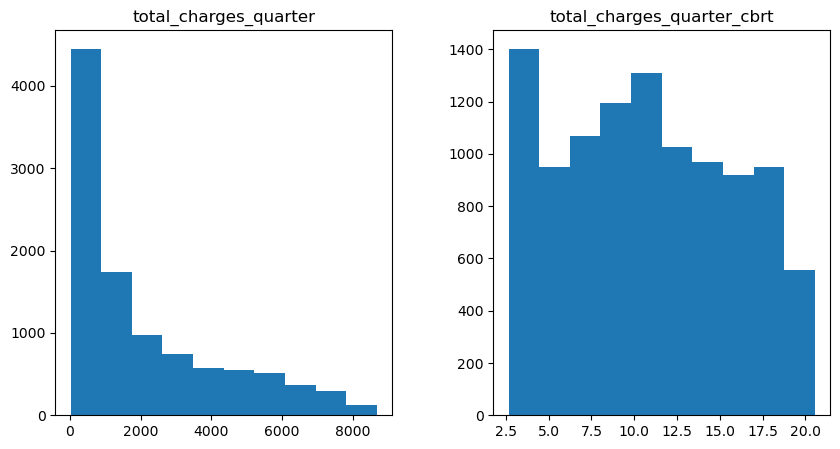

In [ ]:
df_clean3['total_charges_quarter_cbrt'] = np.cbrt(df_clean3['total_charges_quarter'])

df_clean3[['total_charges_quarter', 'total_charges_quarter_cbrt']].fillna("").hist(bins = 10, figsize=(10,5), grid = False)
plt.show()

In [ ]:
scaler_tenure.transform([[200]])[0][0]

4.557420104905714

In [ ]:
std_cols = ['total_monthly_fee', 
            'avg_gb_download_monthly', 
            'avg_long_distance_fee_monthly', 'population']
df_clean4 = df_clean3.copy()

scaler = StandardScaler()
df_clean4[std_cols] = scaler.fit_transform(df_clean4[std_cols])


print("BEFORE")
display(df_clean3[std_cols])
print("\nAFTER")
display(df_clean4[std_cols])

BEFORE


,total_monthly_fee,avg_gb_download_monthly,avg_long_distance_fee_monthly,population
0,85.20,16,26.41,29847
1,79.85,42,48.38,31963
2,114.05,29,5.81,404
3,94.80,28,10.57,4101
4,95.10,20,12.96,282
...,...,...,...,...
10343,105.65,26,33.25,32804
10344,73.65,48,14.53,1107
10345,71.05,24,4.60,1745
10346,53.65,17,40.42,40077



AFTER


,total_monthly_fee,avg_gb_download_monthly,avg_long_distance_fee_monthly,population
0,0.594205,-0.259884,0.211196,0.327516
1,0.409508,1.049235,1.637442,0.426803
2,1.590187,0.394675,-1.126113,-1.054007
3,0.925623,0.344325,-0.817104,-0.880536
4,0.935980,-0.058481,-0.661950,-1.059731
...,...,...,...,...
10343,1.300196,0.243623,0.655234,0.466264
10344,0.195467,1.351340,-0.560029,-1.021021
10345,0.105707,0.142922,-1.204664,-0.991084
10346,-0.494989,-0.209534,1.120696,0.807527


In [ ]:
scaler = StandardScaler().fit(df_clean3[['total_monthly_fee', 'avg_gb_download_monthly', 'avg_long_distance_fee_monthly']])
# scaler_tenure = StandardScaler().fit(df_clean3[['total_monthly_fee']])
# scaler_gb_dl = StandardScaler().fit(df_clean3[['avg_gb_download_monthly']])
# scaler_dist_fee = StandardScaler().fit(df_clean3[['avg_long_distance_fee_monthly']])

joblib.dump(scaler, r'..\models\StdScalar.pkl')
# joblib.dump(scaler_tenure, r'..\models\StdScalar_TenureMthFee.pkl')
# joblib.dump(scaler_gb_dl, r'..\models\StdScalar_AvgMthlyGBDownload.pkl')
# joblib.dump(scaler_dist_fee, r'..\models\StdScalar_AvgMthlyLongDistFee.pkl')

['..\\models\\StdScalar_AvgMthlyLongDistFee.pkl']

## Remove Unnecessary Columns

<b><u>Reason(s) for Removal</b></u>
- id-related columns: Does not play a part in determining the churn status
- `churn_category`, `status`& `churn_reason`: An extension of the target variable
- `age`, `num_referrals`, & `num_dependents`: Bin columns are created above for easy training of model
- `city`, `latitude` & `longitude`: Simplified by using first 2 digits of zipcode and have high collinearity with zipcode
- `total_charges_quarter`: Transform to `total_charges_quarter_cbrt` using cube root due to it being highly skewed
- `total_long_distance_fee`: Due to high correlation with `avg_gb_download_monthly`
- 'population`: Not a good and relevant question to ask user to find out from the tool

In [ ]:
df_clean5 = df_clean4.copy()

cols_remove = [
    'customer_id', 'account_id', 'area_id',
    'city', 'latitude', 'longitude',
    'churn_category', 'churn_reason', 'status',
    'age', 'num_referrals', 'num_dependents',
    'total_long_distance_fee', 'total_charges_quarter', 'population'
]


df_clean5.drop(cols_remove, axis = 1, inplace = True)
assert set(df_clean5.columns).isdisjoint(set(cols_remove)), display(set(df_clean5.columns) & set(cols_remove))
display(df_clean5.head(3))


,zip_code,gender,senior_citizen,married,tenure_months,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,contract_type,paperless_billing,payment_method,avg_long_distance_fee_monthly,avg_gb_download_monthly,stream_tv,stream_movie,stream_music,total_monthly_fee,total_refunds,churn_label,num_dependents_bin,num_referrals_bin,age_group,tenure_year,total_charges_quarter_cbrt
0,92,Female,0,1,8,1,Fiber Optic,1,1,1,0,0,0,0,Month-to-Month,1,Credit Card,0.211196,-0.259884,0,1,1,0.594205,0,1,Nil,Nil,Young_Adult,1.0,8.560810
1,90,Male,0,0,10,1,Fiber Optic,1,1,0,0,1,0,1,Month-to-Month,1,Credit Card,1.637442,1.049235,0,0,0,0.409508,0,0,Nil,Nil,Young_Adult,1.0,9.609445
2,95,Male,0,1,72,1,Fiber Optic,1,1,1,1,1,1,1,Two Year,1,Credit Card,-1.126113,0.394675,1,1,1,1.590187,0,0,1,4 or more,Older_Adults,6.0,20.238153


# Train Model

In [ ]:
# Separate into features and target columns
feat_selection = df_clean5.columns.tolist()
feat_selection.remove("churn_label")

# Make the observations more randomised
df_clean6 = shuffle(df_clean5, random_state = 1).reset_index()

# Train-test Split
X = df_clean6[feat_selection]
Y = df_clean6['churn_label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

## Option 1: CatBoost

In [ ]:
cat_feat = ['zip_code', 'gender', 'internet_type', 'contract_type', 'payment_method', 'num_dependents_bin', 'num_referrals_bin', 'age_group' ]
catboost = CatBoostClassifier(random_state = 5, cat_features= cat_feat)

catboost.fit(X, Y)

feature_importance = catboost.feature_importances_

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)


top10_features = importance_df['Feature'].head(10).tolist()
top10_features

Learning rate set to 0.027943
0:	learn: 0.6746373	total: 203ms	remaining: 3m 22s
1:	learn: 0.6580038	total: 244ms	remaining: 2m 1s
2:	learn: 0.6425180	total: 285ms	remaining: 1m 34s
3:	learn: 0.6253833	total: 325ms	remaining: 1m 21s
4:	learn: 0.6102101	total: 366ms	remaining: 1m 12s
5:	learn: 0.5953354	total: 403ms	remaining: 1m 6s
6:	learn: 0.5831085	total: 447ms	remaining: 1m 3s
7:	learn: 0.5714114	total: 483ms	remaining: 59.9s
8:	learn: 0.5612882	total: 525ms	remaining: 57.8s
9:	learn: 0.5517315	total: 568ms	remaining: 56.2s
10:	learn: 0.5435145	total: 611ms	remaining: 54.9s
11:	learn: 0.5348697	total: 650ms	remaining: 53.5s
12:	learn: 0.5258007	total: 689ms	remaining: 52.3s
13:	learn: 0.5182190	total: 727ms	remaining: 51.2s
14:	learn: 0.5106137	total: 769ms	remaining: 50.5s
15:	learn: 0.5040217	total: 811ms	remaining: 49.9s
16:	learn: 0.4975098	total: 850ms	remaining: 49.2s
17:	learn: 0.4920633	total: 894ms	remaining: 48.8s
18:	learn: 0.4867695	total: 934ms	remaining: 48.2s
19:	lea

['contract_type',
 'num_dependents_bin',
 'num_referrals_bin',
 'total_monthly_fee',
 'tenure_months',
 'avg_long_distance_fee_monthly',
 'total_charges_quarter_cbrt',
 'zip_code',
 'payment_method',
 'avg_gb_download_monthly']

In [ ]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X[top10_features], Y, test_size=0.3, random_state=0)

In [ ]:
# Instantiate the model object
cat_top10features = ['contract_type', 'num_dependents_bin', 'num_referrals_bin', 'zip_code', 'payment_method']
catboost = CatBoostClassifier(random_state = 5, cat_features= cat_top10features)
param = {'iterations' : list(range(100, 1100, 100)), 'learning_rate': [0.01, 0.05, 0.1, 0.5], 'max_depth' : [2, 4, 8]}

catboost_grid = RandomizedSearchCV(catboost, param_distributions = param, n_iter = 3, n_jobs = -1, scoring = 'accuracy')
catboost_grid.fit(X_train_cat, y_train_cat)

y_pred_proba_cat= catboost_grid.predict_proba(X_test_cat)[:,1]
y_pred_cat = catboost_grid.predict(X_test_cat)

print("Best Hyperparameters found:", catboost_grid.best_params_)

print("Accuracy", metrics.accuracy_score(y_test_cat, y_pred_cat))
print("Recall", metrics.recall_score(y_test_cat, y_pred_cat))
print("Precision", metrics.precision_score(y_test_cat, y_pred_cat))
print("F1 Score", metrics.f1_score(y_test, y_pred_cat))


0:	learn: 0.4866572	total: 97.6ms	remaining: 1m 17s
1:	learn: 0.4114092	total: 182ms	remaining: 1m 12s
2:	learn: 0.3909457	total: 286ms	remaining: 1m 15s
3:	learn: 0.3748290	total: 362ms	remaining: 1m 12s
4:	learn: 0.3641832	total: 453ms	remaining: 1m 12s
5:	learn: 0.3529742	total: 546ms	remaining: 1m 12s
6:	learn: 0.3468005	total: 684ms	remaining: 1m 17s
7:	learn: 0.3444258	total: 815ms	remaining: 1m 20s
8:	learn: 0.3354955	total: 943ms	remaining: 1m 22s
9:	learn: 0.3335899	total: 1.09s	remaining: 1m 26s
10:	learn: 0.3322438	total: 1.18s	remaining: 1m 24s
11:	learn: 0.3252196	total: 1.3s	remaining: 1m 25s
12:	learn: 0.3201464	total: 1.42s	remaining: 1m 25s
13:	learn: 0.3134953	total: 1.52s	remaining: 1m 25s
14:	learn: 0.3028740	total: 1.63s	remaining: 1m 25s
15:	learn: 0.2996051	total: 1.73s	remaining: 1m 24s
16:	learn: 0.2909395	total: 1.82s	remaining: 1m 23s
17:	learn: 0.2852285	total: 1.9s	remaining: 1m 22s
18:	learn: 0.2817875	total: 1.97s	remaining: 1m 21s
19:	learn: 0.2764270	to

In [ ]:
# Calculate the (1) false positive rate, (2) true positive rate, and (3) thresholds
y_pred_proba = list(y_pred_proba_cat) # converting to list
fpr, tpr, thresholds = roc_curve(y_test_cat, y_pred_proba_cat)

# Plotting the chart
fig = px.area(
    x=fpr, y=tpr,
    title=f'CatBoost ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# This part is just for formatting & adding the dash-line 
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')


fig.show()

In [ ]:
joblib.dump(catboost_grid, r'..\models\catboost.pkl')

['..\\models\\catboost.pkl']

## Light Gradient Boost

In [ ]:
X_lgb = X.copy()
# X_lgb['zip_code'] = X_lgb['zip_code'].astype(str)
for col in cat_feat:
    X_lgb[col] = X_lgb[col].astype('category')


In [ ]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_lgb, Y)

feature_importance_lgbm = lgbm.feature_importances_

# Convert to DataFrame for better visualization
importance_df_lgb = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance_lgbm})
importance_df_lgb = importance_df_lgb.sort_values(by="Importance", ascending=False)


top10_features_lgb = importance_df_lgb['Feature'].head(10).tolist()
top10_features_lgb

[LightGBM] [Info] Number of positive: 5174, number of negative: 5174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 10348, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


['total_monthly_fee',
 'avg_long_distance_fee_monthly',
 'total_charges_quarter_cbrt',
 'tenure_months',
 'avg_gb_download_monthly',
 'num_referrals_bin',
 'num_dependents_bin',
 'contract_type',
 'zip_code',
 'payment_method']

In [ ]:
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_lgb[top10_features_lgb], Y, test_size=0.3, random_state=0)



In [ ]:
param_grid = {
    'num_leaves': [20, 31, 40],  # Controls complexity
    'learning_rate': [0.01, 0.1, 0.2],  # Step size
    'n_estimators': [100, 200, 500],  # Number of trees
    'max_depth': [-1, 10, 20],  # Tree depth (-1 = unlimited)
}

# Perform Grid Search
grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_lgb, y_train_lgb)

y_pred_proba_lgb= grid_search.predict_proba(X_test_lgb)[:,1]
y_pred_lgb = grid_search.predict(X_test_lgb)

print("Best Hyperparameters found:", grid_search.best_params_)

print("Accuracy", metrics.accuracy_score(y_test_lgb, y_pred_lgb))
print("Recall", metrics.recall_score(y_test_lgb, y_pred_lgb))
print("Precision", metrics.precision_score(y_test_lgb, y_pred_lgb))
print("F1 Score", metrics.f1_score(y_test_lgb, y_pred_lgb))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 2880, number of negative: 2914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 5794, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497066 -> initscore=-0.011736
[LightGBM] [Info] Start training from score -0.011736
[LightGBM] [Info] Number of positive: 2880, number of negative: 2914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 910
[LightGBM] [Info] Number of data points in the train set: 5794, number of used features: 10
[LightGBM] [Info] [binary:Bo

In [ ]:
# Calculate the (1) false positive rate, (2) true positive rate, and (3) thresholds
y_pred_proba = list(y_pred_proba_lgb) # converting to list
fpr, tpr, thresholds = roc_curve(y_test_lgb, y_pred_proba_lgb)

# Plotting the chart
fig = px.area(
    x=fpr, y=tpr,
    title=f'LightGBM ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)

# This part is just for formatting & adding the dash-line 
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')


fig.show()

In [ ]:
joblib.dump(grid_search, r'..\models\LightGBM.pkl')

['Model\\LightGBM.pkl']